# Overall approach

We have two different inputs: 

1) Bottom level forecasts on item level (30490 signal) that are derived from a lgbm model that models a probability of this item being bought based on datatime features, price features and a few other features that are not time dependent. (Credits: https://www.kaggle.com/kyakovlev/m5-simple-fe)
2) Top level forecasts for the levels 1-5 that are created with N-Beats. 

We can now aggregate the bottom level "probabilit draws" up to the levels 1-5. By comparing/aligning the possible results we can select the most suitable probability distribution for the forecast period. ( The multiplier in the custom loss of the bottom level lgbm models seems to help adjust for trend or other effects not fully understood yet)

### Overall analysis result: 

The multiplier 0.95 seems to represent the lowest available fit so we build an ensemble with the 2 upper and 2 lower distributions to generate a robust test loss.
<br><br>
Final-11: 0.9 <br>
Final-12: 0.93 <br>
Final-17: 0.95 <br>
Final-13: 0.97 <br>
Final-16: 0.99

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.simplefilter(action='ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns



## Load NBEATS reference predictions for global alignment

NBeats predictions trained and predicted on Colab with two different settings (only change in setting is num_epochs to get slightly different ensembles)

In [2]:
nbeats_pred01_df = pd.read_csv('../input/m5alignnbeatsv01/nbeats_toplvl_forecasts1.csv')
nbeats_pred02_df = pd.read_csv('../input/m5alignnbeatsv02/nbeats_toplvl_forecasts2.csv')

#nbeats_pred_df.head()

## Load bottom level lgb predictions for alignment

In [3]:
BUILD_ENSEMBLE = True

In [4]:
if BUILD_ENSEMBLE:
    
    pred_01_df = pd.read_csv('../input/m5-final-13/submission_v1.csv')
    pred_02_df = pd.read_csv('../input/fork-of-m5-final-11/submission_v1.csv')
    pred_03_df = pd.read_csv('../input/m5-final-12/submission_v1.csv')
    pred_04_df = pd.read_csv('../input/m5-final-17/submission_v1.csv')
    pred_05_df = pd.read_csv('../input/m5-final-16/submission_v1.csv')
    #pred_06_df = pd.read_csv('..')

    avg_pred = ( np.array(pred_01_df.values[:,1:]) 
                + np.array(pred_02_df.values[:,1:]) 
                + np.array(pred_03_df.values[:,1:])
                + np.array(pred_04_df.values[:,1:])  
                + np.array(pred_05_df.values[:,1:])  
               # + np.array(pred_06_df.values[:,1:])  
               ) /5.0
    
    ## Loading predictions
    valid_pred_df = pd.DataFrame(avg_pred, columns=pred_01_df.columns[1:])
    submission_pred_df = pd.concat([pred_01_df['id'],valid_pred_df],axis=1)
    
else:
    print('Should not submit single distibution')
    #submission_pred_df = pd.read_csv('../input/m5-final-13/submission_v1.csv')

## Fill validation rows - we have no info about validation scoring


Even though it would not make sense at all to score public validation data it might be safest to set the submission validation values to the ground truth....

Spamming the LB a bit more ... 

In [5]:
validation_gt_data = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')
validation_gt_data['id'] = validation_gt_data['id'].str.replace('_evaluation','_validation')
validation_gt_data = validation_gt_data.drop(['item_id','dept_id','cat_id','store_id','state_id'],axis=1)
validation_gt_data = pd.concat([validation_gt_data[['id']],validation_gt_data.iloc[:,-28:]],axis=1)
validation_gt_data.columns=submission_pred_df.columns.values
#validation_gt_data

In [6]:
submission_pred_df = pd.concat([validation_gt_data, submission_pred_df.iloc[30490:,:]],axis=0).reset_index(drop=True)
submission_pred_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.219936,0.141881,0.121371,0.113582,0.191747,0.311487,0.303103,0.192112,0.154475,...,0.251565,0.472076,0.520193,0.320124,0.343796,0.358301,0.255742,0.246624,0.364968,0.303362
60976,FOODS_3_824_WI_3_evaluation,0.120583,0.0397095,0.0194102,0.0116211,0.0734238,0.17584,0.167642,0.372619,0.0257394,...,0.101491,0.369854,0.410143,0.181396,0.273316,0.305319,0.130713,0.120491,0.220022,0.0816773
60977,FOODS_3_825_WI_3_evaluation,0.749637,0.671399,0.648335,0.632938,0.725125,0.836541,0.839531,0.701662,0.675358,...,0.897051,1.22711,1.28929,0.95453,1.07193,1.09453,0.878018,0.876464,0.971499,0.919294
60978,FOODS_3_826_WI_3_evaluation,1.02429,0.94255,0.868299,0.861524,1.09043,1.33073,1.27164,0.953977,0.998147,...,1.14655,1.54798,1.52792,1.15864,1.26612,1.22581,1.07022,1.1636,1.3958,1.40572


## Only work on evaluation forecasts

In [7]:
bottom_lvl_pred_df = submission_pred_df.iloc[30490:,:].reset_index(drop=True)
bottom_lvl_pred_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.734733,0.670524,0.674388,0.675073,0.776193,0.892129,0.870431,0.837973,0.728293,...,0.819125,0.907831,0.903448,0.748878,0.698198,0.700372,0.705178,0.800964,0.91774,0.753888
1,HOBBIES_1_002_CA_1_evaluation,0.259645,0.191252,0.193533,0.192819,0.28008,0.376336,0.358172,0.341967,0.254997,...,0.325382,0.394042,0.38318,0.262074,0.206707,0.207352,0.212006,0.298281,0.398519,0.241869
2,HOBBIES_1_003_CA_1_evaluation,0.352623,0.286198,0.288479,0.287765,0.374389,0.470445,0.454505,0.417692,0.352019,...,0.428478,0.495644,0.487006,0.369055,0.316184,0.316829,0.321483,0.407121,0.505865,0.397951
3,HOBBIES_1_004_CA_1_evaluation,1.59473,1.48829,1.49425,1.56413,1.93376,2.97923,3.18904,1.82032,1.52173,...,1.98906,3.02703,3.23866,1.59139,1.49417,1.49482,1.56626,1.9661,3.01555,2.87232
4,HOBBIES_1_005_CA_1_evaluation,0.973369,0.893243,0.897996,0.901417,1.0467,1.33421,1.35232,1.01347,0.956554,...,1.06303,1.35817,1.39305,1.01891,0.965586,0.965403,0.973151,1.11692,1.40712,1.27971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0.219936,0.141881,0.121371,0.113582,0.191747,0.311487,0.303103,0.192112,0.154475,...,0.251565,0.472076,0.520193,0.320124,0.343796,0.358301,0.255742,0.246624,0.364968,0.303362
30486,FOODS_3_824_WI_3_evaluation,0.120583,0.0397095,0.0194102,0.0116211,0.0734238,0.17584,0.167642,0.372619,0.0257394,...,0.101491,0.369854,0.410143,0.181396,0.273316,0.305319,0.130713,0.120491,0.220022,0.0816773
30487,FOODS_3_825_WI_3_evaluation,0.749637,0.671399,0.648335,0.632938,0.725125,0.836541,0.839531,0.701662,0.675358,...,0.897051,1.22711,1.28929,0.95453,1.07193,1.09453,0.878018,0.876464,0.971499,0.919294
30488,FOODS_3_826_WI_3_evaluation,1.02429,0.94255,0.868299,0.861524,1.09043,1.33073,1.27164,0.953977,0.998147,...,1.14655,1.54798,1.52792,1.15864,1.26612,1.22581,1.07022,1.1636,1.3958,1.40572


## Reconstruct level descriptions for aggregation

In [8]:
name_cols = bottom_lvl_pred_df.id.str.split(pat='_',expand=True)
name_cols['dept_id']=name_cols[0]+'_'+name_cols[1]
name_cols['store_id']=name_cols[3]+'_'+name_cols[4]
name_cols = name_cols.rename(columns={0: "cat_id", 3: "state_id"})
name_cols = name_cols.drop([1,2,4,5],axis=1)
bottom_lvl_pred_df = pd.concat([name_cols,bottom_lvl_pred_df],axis=1)

## Build aggregates of predictions

In [9]:
# Get column groups
cat_cols = ['id', 'dept_id', 'cat_id',  'store_id', 'state_id']
ts_cols = [col for col in bottom_lvl_pred_df.columns if col not in cat_cols]
ts_dict = {t: int(t[1:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % bottom_lvl_pred_df.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, bottom_lvl_pred_df[col].nunique()))


  unique forecasts: 30490
   N_unique id: 30490
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [10]:
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(bottom_lvl_pred_df[ts_cols].sum()).transpose()
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]

In [11]:
# 2. All products by state (3 series)
state_sales = bottom_lvl_pred_df.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)

In [12]:
# 3. All products by store (10 series)
store_sales = bottom_lvl_pred_df.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)

In [13]:
# 4. All products by category (3 series)
cat_sales = bottom_lvl_pred_df.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)


In [14]:
# 5. All products by department (7 series)
dept_sales = bottom_lvl_pred_df.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)

In [15]:
all_pred_agg = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)


In [16]:
all_pred_agg.head()

,id_str,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,all,39361.355909,36132.272762,36264.360447,36066.990848,40730.206175,48137.773595,48637.684395,43422.600524,37082.377679,...,44267.748229,54524.809962,56086.707061,43880.130736,41415.899313,42402.098100,39715.729455,43845.559688,52021.465934,46558.396315
1,CA,17380.932254,15692.364728,15508.502937,15495.850049,17296.654105,21029.081444,21919.107177,20138.070292,16495.168829,...,19018.586846,22989.235238,24028.240124,18452.704538,17036.059370,16713.128028,16746.878534,18745.545068,23162.616120,20214.483635
2,TX,11088.999278,9907.972130,10296.618899,10009.015747,10961.377131,12652.200968,13070.199580,11611.967466,9840.651443,...,11522.335011,14099.088438,15005.390511,12907.572017,10796.192791,11777.144536,10753.012485,11717.469802,13597.292810,12449.919215
3,WI,10891.424377,10531.935905,10459.238612,10562.125052,12472.174939,14456.491183,13648.377638,11672.562766,10746.557407,...,13726.826373,17436.486285,17053.076427,12519.854182,13583.647153,13911.825536,12215.838436,13382.544819,15261.557004,13893.993465
4,CA_1,4359.538102,3793.448423,3758.038901,3727.254350,4417.757506,5426.880946,5666.528769,5134.651105,4111.344666,...,4866.998534,5839.111603,6104.505269,4643.644861,4068.962096,4020.556018,4088.502311,4786.093562,5914.912237,5267.197636


In [17]:
nbeats_pred01_df.head()

,id_str,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,all,40502.406250,37299.949219,35913.734375,36490.351562,40493.453125,49690.921875,50267.492188,40292.078125,38834.312500,...,45237.441406,55035.082031,56011.789062,44399.546875,39156.070312,39142.035156,39473.808594,43619.835938,52292.468750,52528.546875
1,CA,17762.128906,16157.653320,15755.197266,15994.518555,17350.804688,22099.669922,22977.597656,17655.519531,17150.152344,...,18114.232422,22858.136719,24466.806641,18297.158203,15824.593750,15869.204102,16305.800781,18060.697266,22462.503906,23398.699219
2,TX,11748.431641,10582.083984,10431.586914,10332.617188,11103.828125,13271.310547,13544.303711,11198.822266,10483.642578,...,11984.874023,14124.030273,14777.329102,12459.186523,11039.014648,10814.106445,10959.742188,11743.292969,13282.212891,13951.003906
3,WI,11511.517578,10639.640625,9723.769531,9986.248047,12382.298828,14711.703125,13937.206055,11329.450195,11275.126953,...,14344.417969,18032.074219,17779.634766,13459.319336,12759.851562,13092.227539,12552.404297,14079.134766,16195.298828,14909.231445
4,CA_1,4519.851562,3997.765137,3929.886719,3966.027832,4423.316406,5665.089844,5948.690430,4471.152832,4307.958008,...,4691.570801,5979.555664,6343.354980,4667.213867,4013.643066,4039.996582,4158.328125,4786.462402,5944.257324,6142.210938


# Calculating comparision metrics

## Interpretation

If prediction is bigger than "true" values error will be positive -> prediction is overshooting (pos error)

If prediction is smaller than "true" values error will be negative -> prediction is undershooting (neg error) 


## NBeats 01

In [18]:
metrics_df = nbeats_pred01_df[['id_str']]

## Calculate errors
## CAUTION: nbeats_pred_df is "truth"/actual values in this context
error = ( np.array(all_pred_agg.values[:,1:]) - np.array(nbeats_pred01_df.values[:,1:]) ) 

## Calc RMSSE
successive_diff = np.diff(nbeats_pred01_df.values[:,1:]) ** 2
denom = successive_diff.mean(1)

num = error.mean(1)**2
rmsse = num / denom

metrics_df['rmsse'] = rmsse

## Not so clean Pandas action :-) - supressing warnings for now...
metrics_df['mean_error'] = error.mean(1)
metrics_df['mean_abs_error'] = np.absolute(error).mean(1)

squared_error = error **2
mean_squ_err = np.array(squared_error.mean(1), dtype=np.float64) 

metrics_df['rmse'] = np.sqrt( mean_squ_err )

metrics_df

,id_str,rmsse,mean_error,mean_abs_error,rmse
0,all,8.27424e-05,-50.2829,1286.01,1786.853358
1,CA,0.00381747,172.507,774.438,1011.312975
2,TX,0.00732117,-106.077,405.194,510.311591
3,WI,0.00941973,-179.325,580.868,669.370081
4,CA_1,0.00651318,-62.3624,165.797,251.960114
5,CA_2,0.00551455,-76.8658,225.135,338.398164
6,CA_3,0.107922,247.093,373.807,437.354041
7,CA_4,0.0614284,-55.3935,95.1751,128.773389
8,TX_1,0.0606176,-108.084,156.653,191.113022
9,TX_2,8.46274e-06,-1.3454,176.744,222.483737


## NBeats 02

In [19]:
metrics_df = nbeats_pred02_df[['id_str']]

## Calculate errors
## CAUTION: nbeats_pred_df is "truth"/actual values in this context
error = ( np.array(all_pred_agg.values[:,1:]) - np.array(nbeats_pred02_df.values[:,1:]) ) 

## Calc RMSSE
successive_diff = np.diff(nbeats_pred01_df.values[:,1:]) ** 2
denom = successive_diff.mean(1)

num = error.mean(1)**2
rmsse = num / denom

metrics_df['rmsse'] = rmsse

## Not so clean Pandas action :-) - supressing warnings for now...
metrics_df['mean_error'] = error.mean(1)
metrics_df['mean_abs_error'] = np.absolute(error).mean(1)

squared_error = error **2
mean_squ_err = np.array(squared_error.mean(1), dtype=np.float64) 

metrics_df['rmse'] = np.sqrt( mean_squ_err )

metrics_df

,id_str,rmsse,mean_error,mean_abs_error,rmse
0,all,0.00305457,305.514,1379.94,1891.143323
1,CA,0.00860769,259.038,776.36,1030.913728
2,TX,7.66511e-05,-10.854,387.384,510.797785
3,WI,0.0114014,-197.288,544.022,665.319760
4,CA_1,0.0109519,-80.8668,176.687,276.002335
5,CA_2,2.82492e-06,-1.73973,217.788,312.984258
6,CA_3,0.156913,297.944,425.077,493.631811
7,CA_4,0.0343661,-41.4324,99.2969,135.573592
8,TX_1,0.00765799,-38.4165,126.498,162.735428
9,TX_2,0.00183153,19.7925,168.532,225.869258


# Visualizations

### NBeats 01

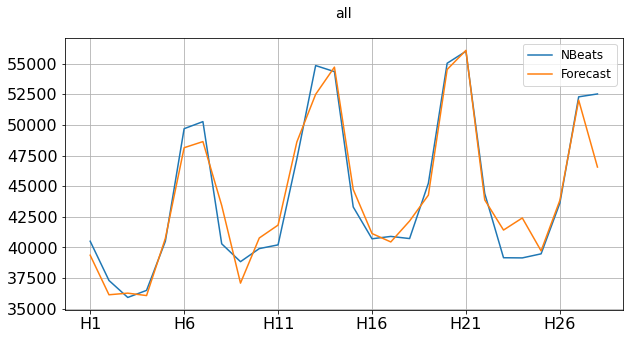

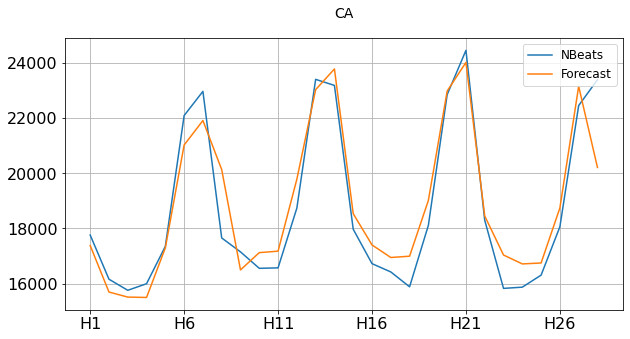

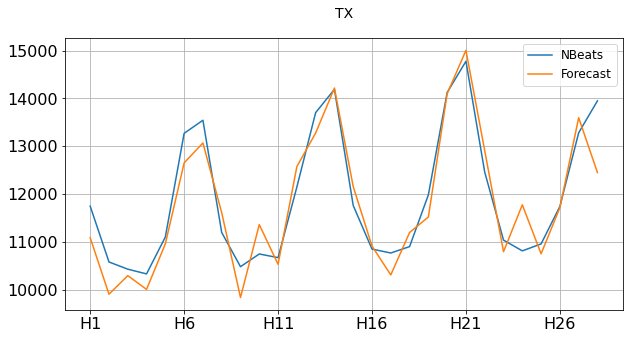

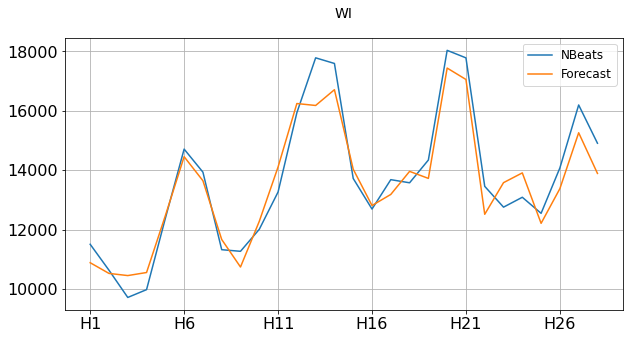

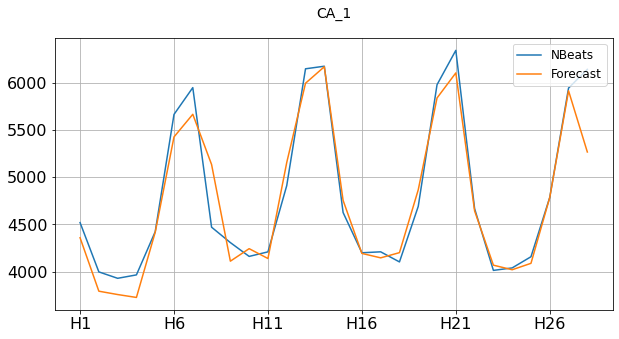

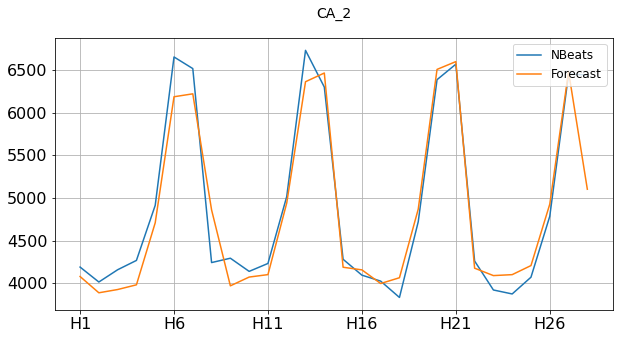

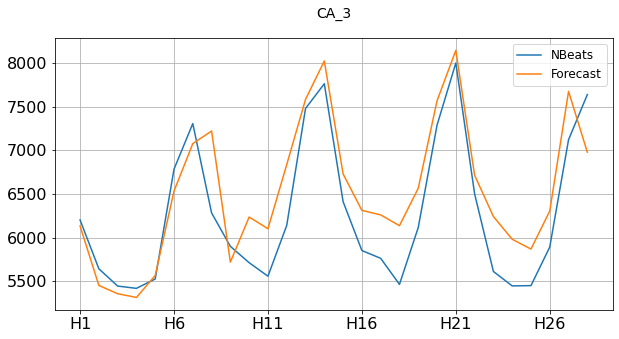

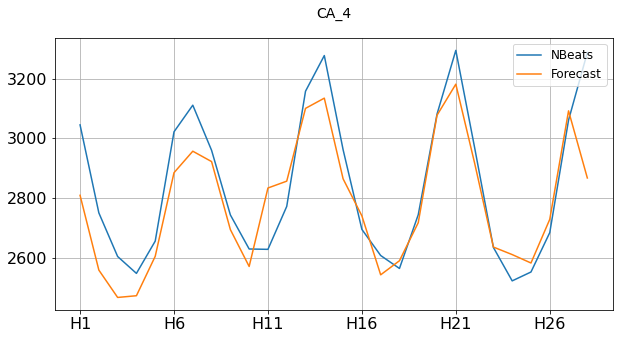

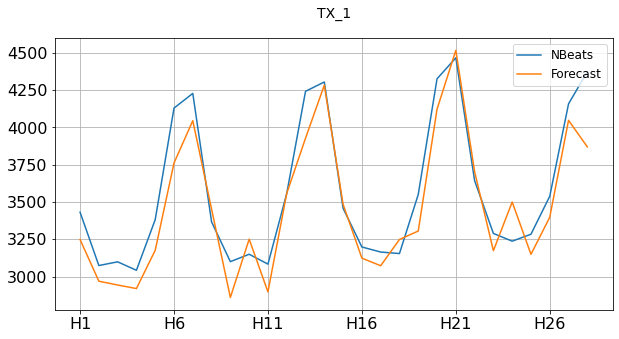

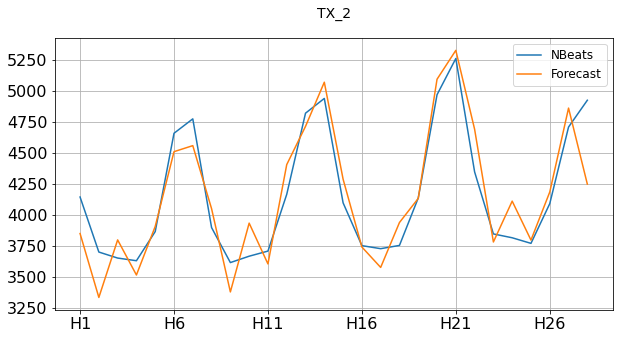

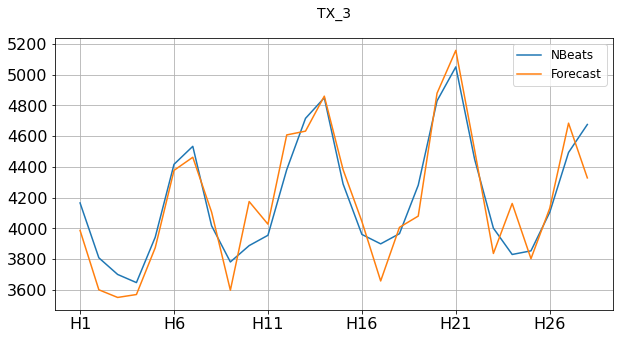

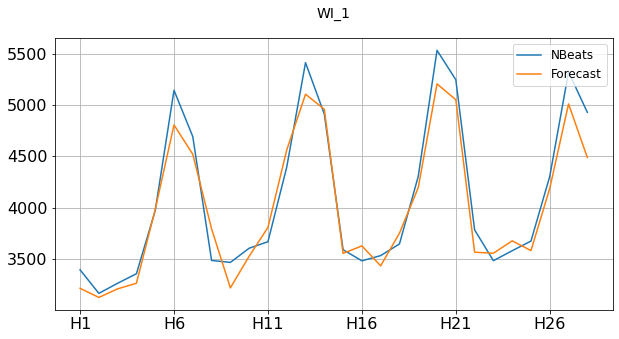

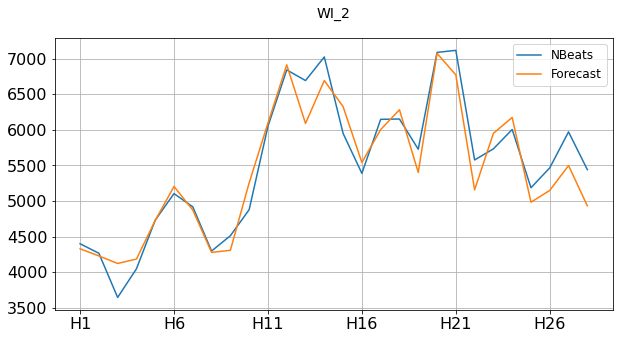

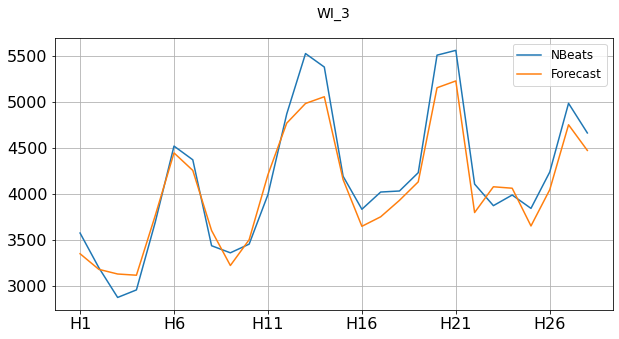

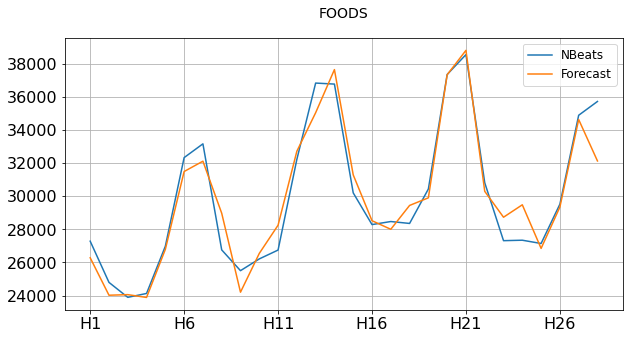

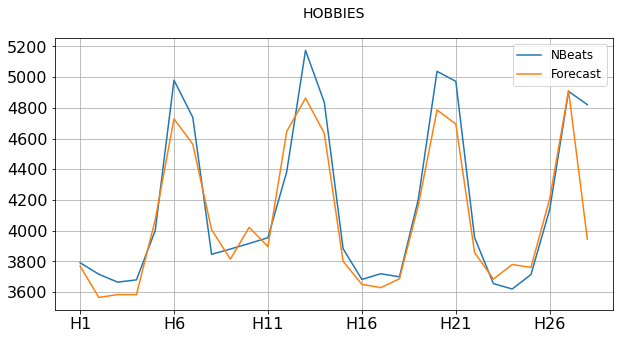

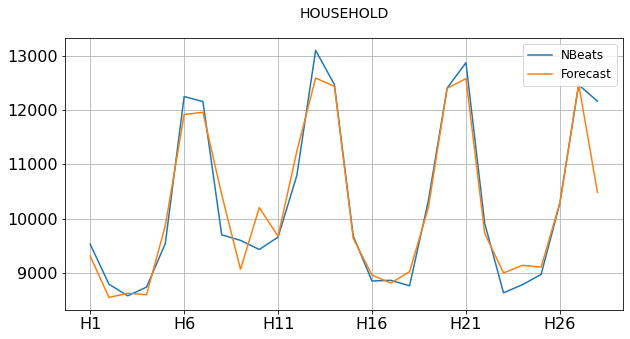

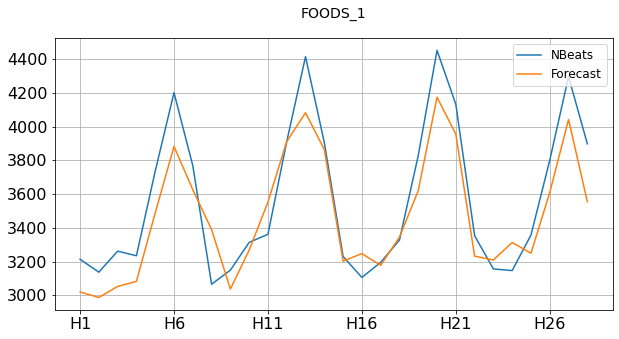

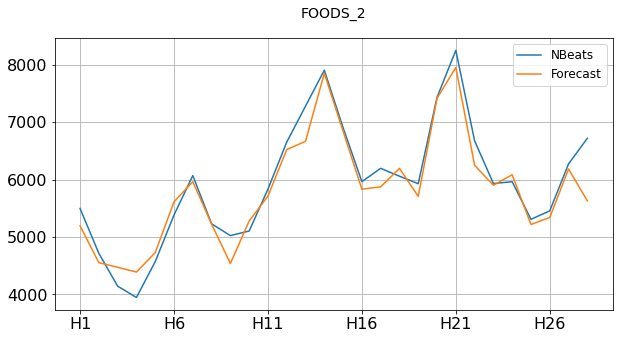

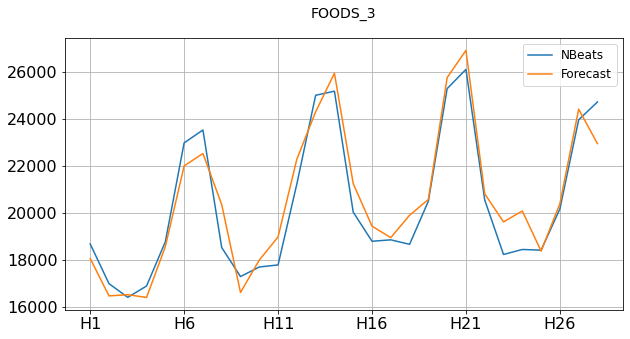

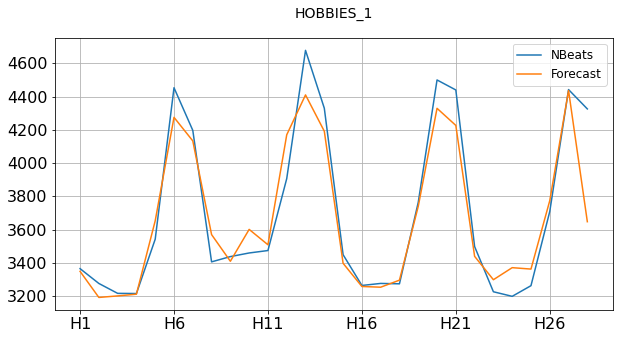

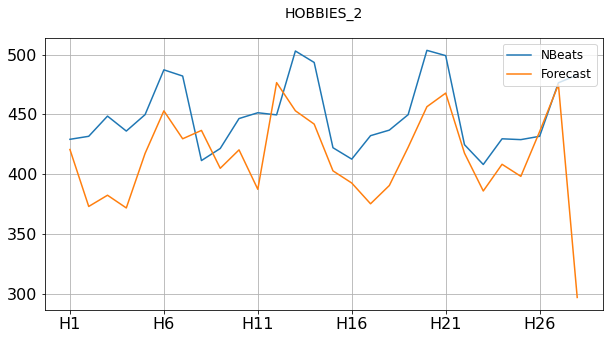

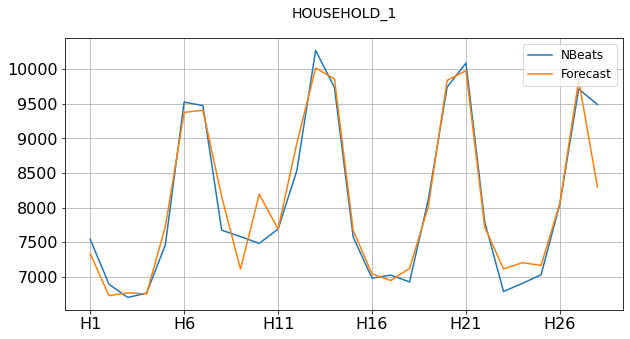

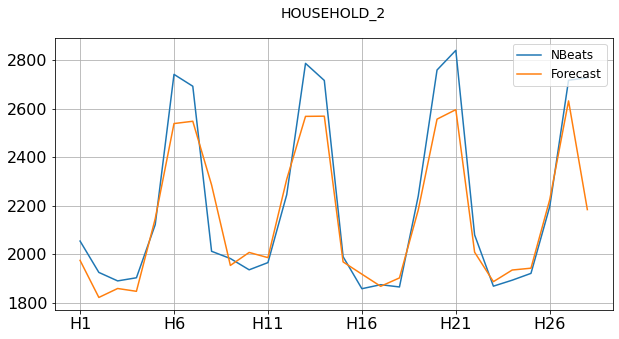

In [20]:
for i in range(0,nbeats_pred01_df.shape[0]):
    plot_df = pd.concat( [nbeats_pred01_df.iloc[i], all_pred_agg.iloc[i] ]  , axis=1, ignore_index=True)
    plot_df = plot_df.iloc[1:,]
    plot_df = plot_df.rename(columns={0:'NBeats',1:'Forecast'})
    plot_df = plot_df.reset_index()
    plot_df['index'] = plot_df['index'].str.replace('F','H')
    #plot_df
    
    ax = plot_df.plot(x='index', y=['NBeats', 'Forecast'] ,figsize=(10,5), grid=True, title=nbeats_pred02_df.iloc[i,0], fontsize=16  )
    ax.legend(loc=1,fontsize=12)
    ax.set_title(ax.get_title(),pad=20, fontdict={'fontsize':14})
    axlabel = ax.axes.get_xaxis().get_label()
    axlabel.set_visible(False)

## NBeats 02

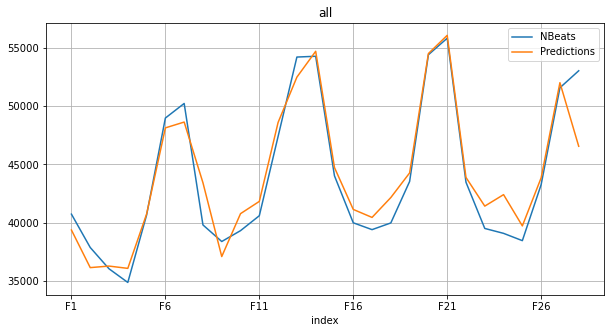

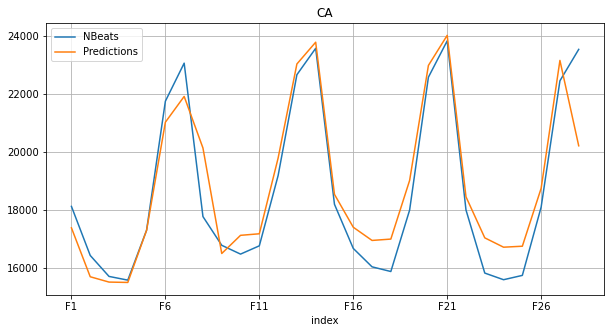

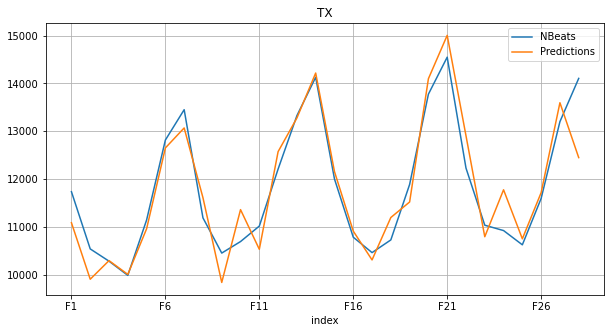

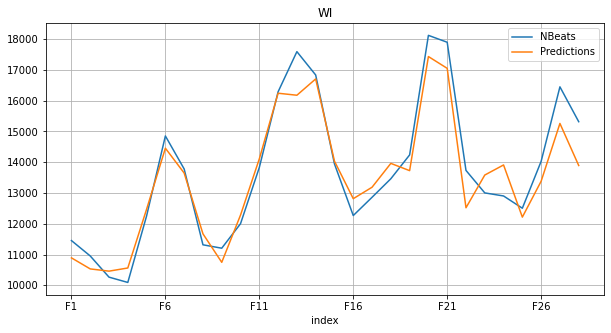

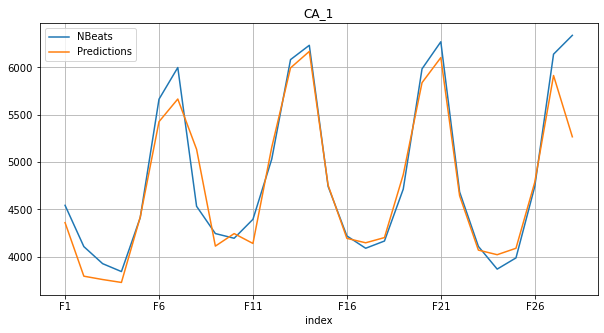

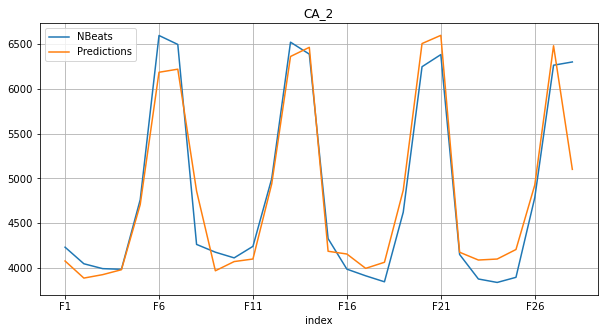

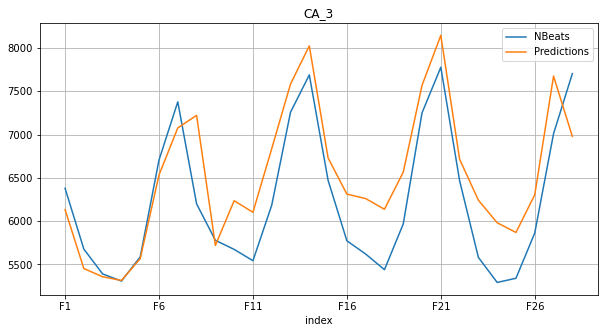

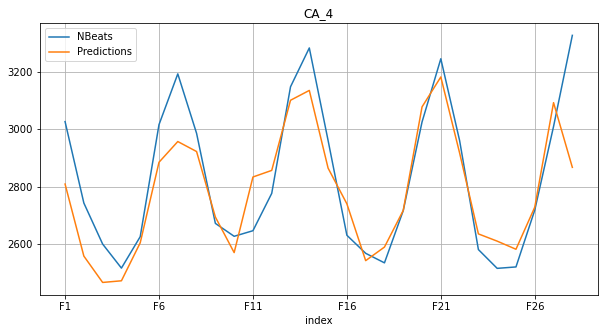

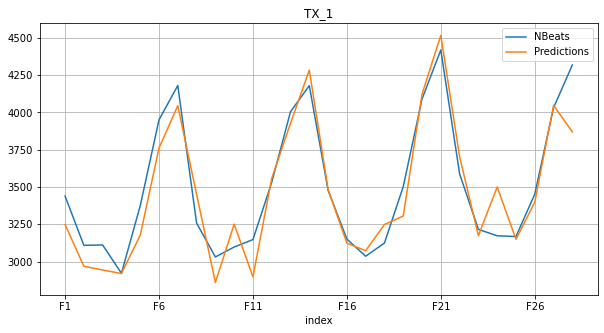

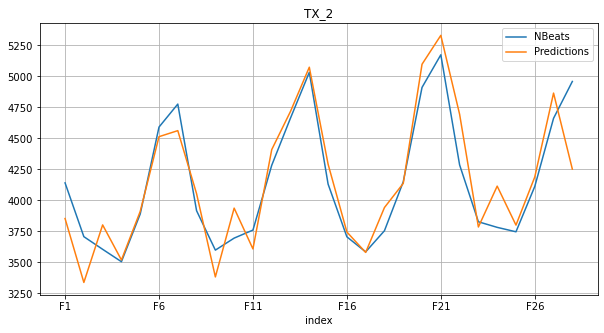

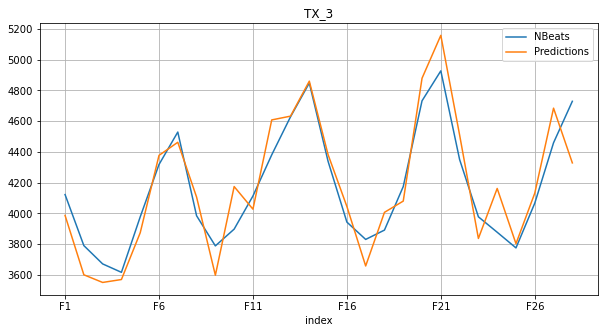

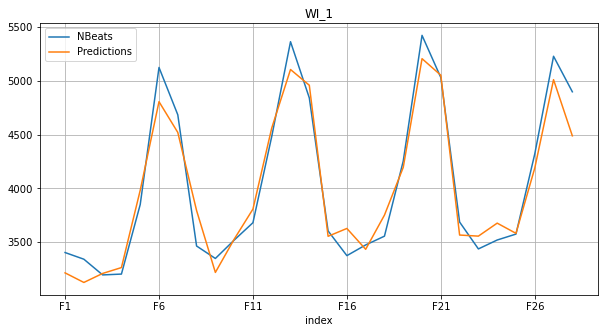

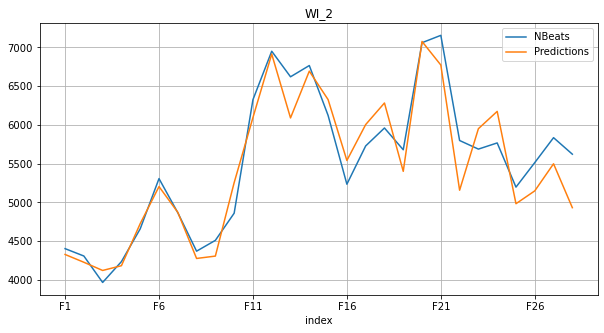

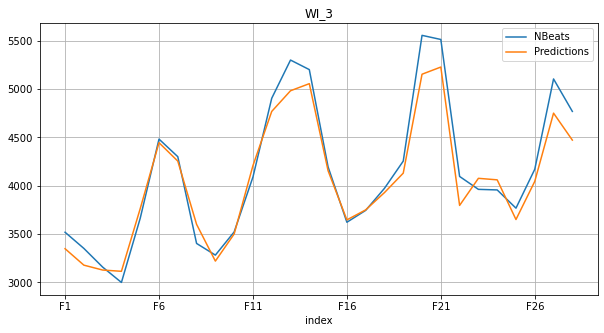

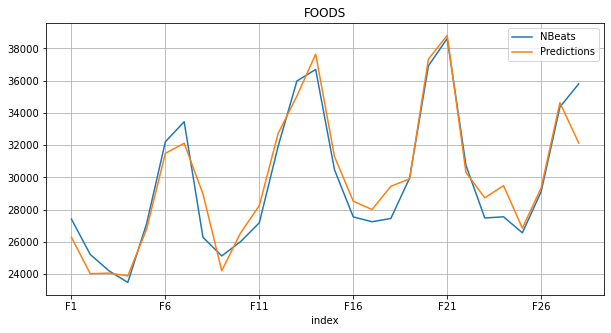

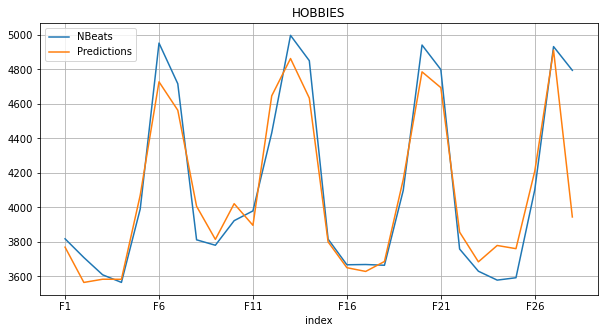

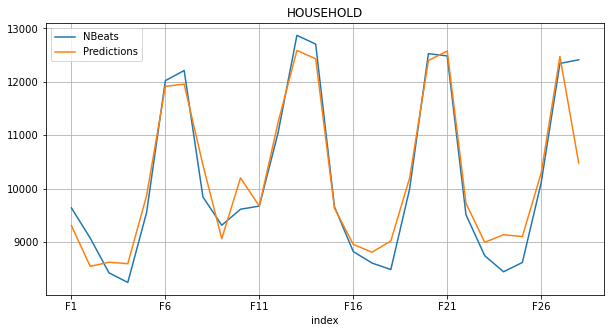

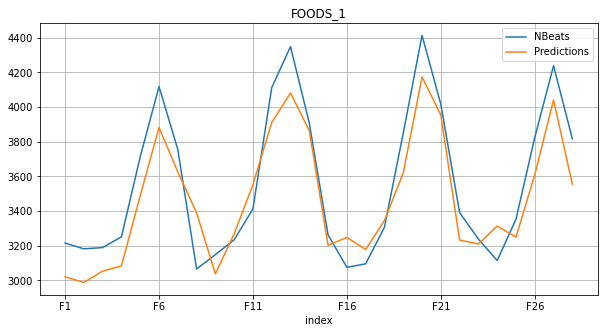

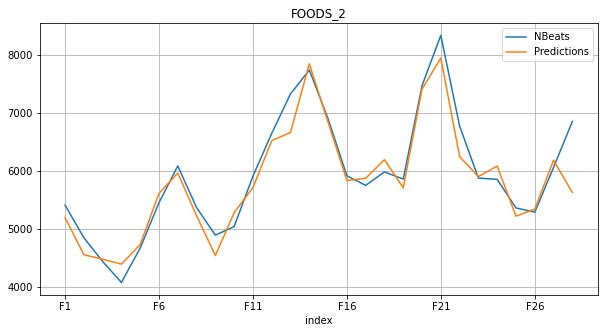

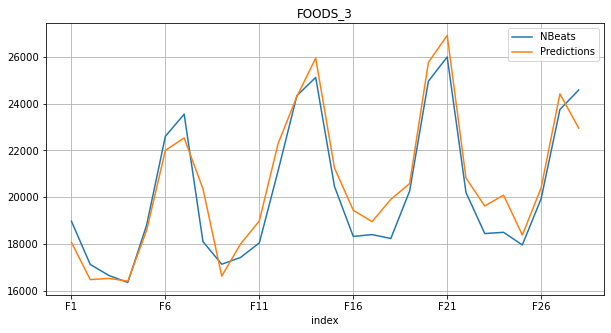

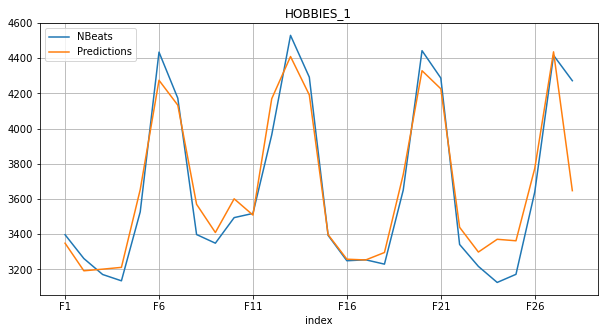

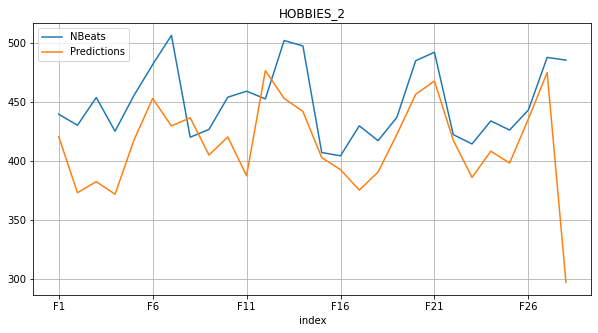

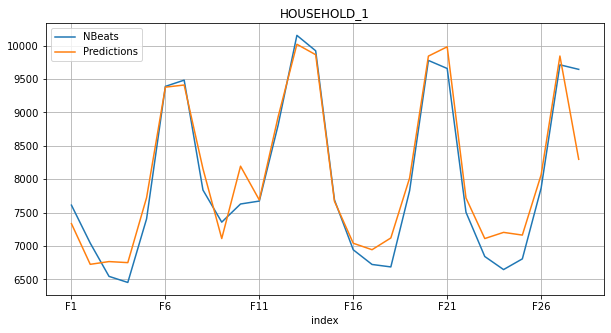

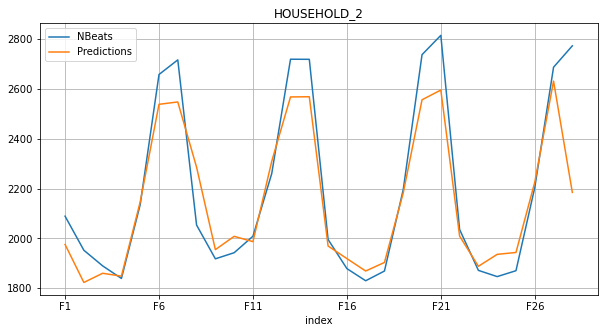

In [21]:
for i in range(0,nbeats_pred02_df.shape[0]):
    plot_df = pd.concat( [nbeats_pred02_df.iloc[i], all_pred_agg.iloc[i] ]  , axis=1, ignore_index=True)
    plot_df = plot_df.iloc[1:,]
    plot_df = plot_df.rename(columns={0:'NBeats',1:'Predictions'})
    plot_df = plot_df.reset_index()
    #plot_df
    
    plot_df.plot(x='index', y=['NBeats', 'Predictions'] ,figsize=(10,5), grid=True, title=nbeats_pred02_df.iloc[i,0]  )

# Submit based on above analysis and manual selection/clearance

In [22]:
submission_pred_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.219936,0.141881,0.121371,0.113582,0.191747,0.311487,0.303103,0.192112,0.154475,...,0.251565,0.472076,0.520193,0.320124,0.343796,0.358301,0.255742,0.246624,0.364968,0.303362
60976,FOODS_3_824_WI_3_evaluation,0.120583,0.0397095,0.0194102,0.0116211,0.0734238,0.17584,0.167642,0.372619,0.0257394,...,0.101491,0.369854,0.410143,0.181396,0.273316,0.305319,0.130713,0.120491,0.220022,0.0816773
60977,FOODS_3_825_WI_3_evaluation,0.749637,0.671399,0.648335,0.632938,0.725125,0.836541,0.839531,0.701662,0.675358,...,0.897051,1.22711,1.28929,0.95453,1.07193,1.09453,0.878018,0.876464,0.971499,0.919294
60978,FOODS_3_826_WI_3_evaluation,1.02429,0.94255,0.868299,0.861524,1.09043,1.33073,1.27164,0.953977,0.998147,...,1.14655,1.54798,1.52792,1.15864,1.26612,1.22581,1.07022,1.1636,1.3958,1.40572


In [23]:
submission_pred_df.to_csv('m5-final-submission.csv', index=False)
